# Рабочая модель

Готово
Готово
Готово


Обучение модели: 100%|██████████████████| 1000/1000 [08:59<00:00,  1.86дерево/s]

Обучение завершено.


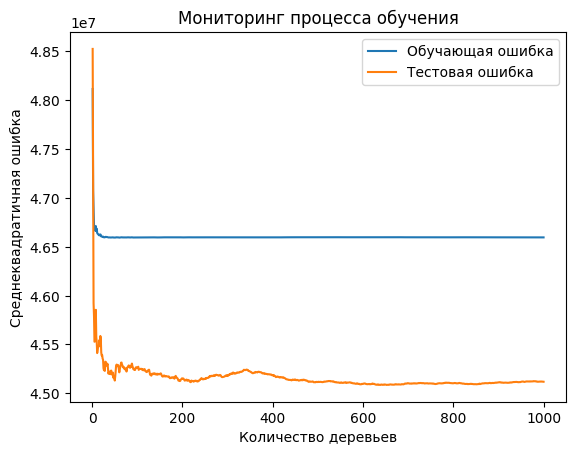

Модель сохранена.


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm  # Импортируем tqdm для отображения прогресса
import joblib  # Импортируем joblib для сохранения модели

# Загрузка данных из файлов
filtred_df = pd.read_parquet('tags-filtered.parquet')
logs_df = pd.read_parquet('parquet-filtered/logs_df_2024-07-08.parquet')
print("Готово")

# Объединение данных по video_id
merged_df = pd.merge(filtred_df, logs_df, on='video_id', how='inner')

# Создание нового признака "популярность видео"
merged_df['popularity'] = (merged_df['v_likes'] - merged_df['v_dislikes']) * merged_df['watchtime']
print("Готово")

# Признаки для обучения
features = ['category_id', 'v_likes', 'v_dislikes', 
            'v_frac_avg_watchtime_1_day_duration', 
            'v_frac_avg_watchtime_7_day_duration', 
            'v_frac_avg_watchtime_30_day_duration']

# Целевая переменная
target = 'popularity'

# Преобразование категориальных переменных
X = pd.get_dummies(merged_df[features], drop_first=True)
y = merged_df[target]

# Обработка данных: замена бесконечных значений и NaN на NaN, затем удаление
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = y[X.index]  # Сохранение соответствующих целевых переменных

# Округление значений в X
X = X.round(decimals=4)

# Берем только первые 500 записей
X = X.iloc[:1000]
y = y.iloc[:1000]

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Готово")

# Используем RandomForestRegressor с отслеживанием прогресса
n_estimators = 1000
train_errors = []
test_errors = []
model = None  # Инициализируем переменную model

for i in tqdm(range(1, n_estimators + 1), desc="Обучение модели", unit="дерево"):
    model = RandomForestRegressor(n_estimators=i, random_state=42)
    model.fit(X_train, y_train)
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_error = np.mean((y_train - train_pred) ** 2)  # Среднеквадратичная ошибка на обучающей выборке
    test_error = np.mean((y_test - test_pred) ** 2)    # Среднеквадратичная ошибка на тестовой выборке
    
    train_errors.append(train_error)
    test_errors.append(test_error)

print("Обучение завершено.")

# Визуализация ошибок
plt.plot(range(1, n_estimators + 1), train_errors, label='Обучающая ошибка')
plt.plot(range(1, n_estimators + 1), test_errors, label='Тестовая ошибка')
plt.xlabel('Количество деревьев')
plt.ylabel('Среднеквадратичная ошибка')
plt.title('Мониторинг процесса обучения')
plt.legend()
plt.show()

# Сохраняем обученную модель
joblib.dump(model, 'random_forest_model.joblib')
print("Модель сохранена.")

## Приколдес

Готово
Готово
Готово


/home/user1/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
324 fits failed out of a total of 648.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "/home/user1/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/user1/.local/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/user1/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/user1/.local/l

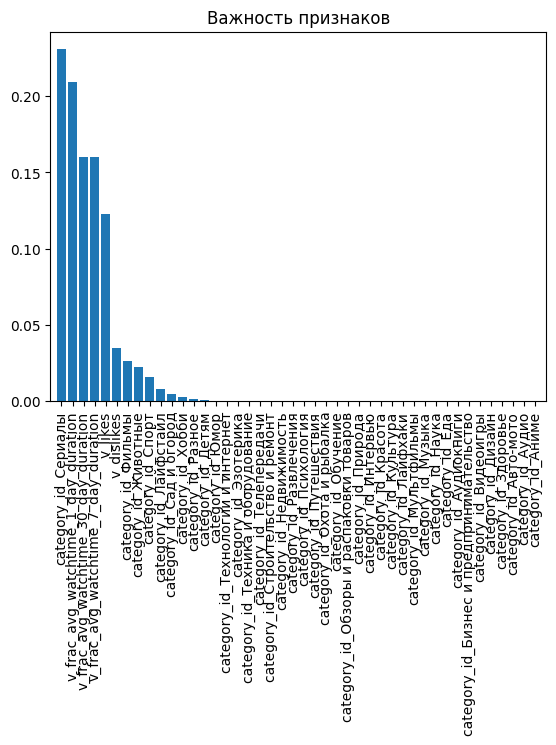

Модель сохранена.


In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib

# Загрузка данных из файлов
filtred_df = pd.read_parquet('tags-filtered.parquet')
logs_df = pd.read_parquet('parquet-filtered/logs_df_2024-07-08.parquet')
print("Готово")

# Объединение данных по video_id
merged_df = pd.merge(filtred_df, logs_df, on='video_id', how='inner')

# Создание нового признака "популярность видео"
merged_df['popularity'] = (merged_df['v_likes'] - merged_df['v_dislikes']) * merged_df['watchtime']
print("Готово")

# Признаки для обучения
features = ['category_id', 'v_likes', 'v_dislikes',
            'v_frac_avg_watchtime_1_day_duration',
            'v_frac_avg_watchtime_7_day_duration',
            'v_frac_avg_watchtime_30_day_duration']

# Целевая переменная
target = 'popularity'

# Преобразование категориальных переменных
X = pd.get_dummies(merged_df[features], drop_first=True)
y = merged_df[target]

# Обработка данных: замена бесконечных значений и NaN на NaN, затем удаление
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = y[X.index]

# Округление значений в X
X = X.round(decimals=4)

# Берем только первые 1000 записей
X = X.iloc[:1000]
y = y.iloc[:1000]

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Готово")

# Подбор гиперпараметров с использованием GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# После завершения обучения визуализируем важность признаков
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Важность признаков")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), np.array(X.columns)[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

# Сохраняем обученную модель
joblib.dump(best_model, 'random_forest_model.joblib')
print("Модель сохранена.")

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Определяем модель
model = RandomForestRegressor(random_state=42)

# Определяем сетку параметров для поиска
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Инициализация GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(X, y)

# Вывод лучших параметров
best_params = grid_search.best_params_

# Переводим параметры в проценты
n_estimators_percent = (best_params['n_estimators'] / 300) * 100  # 300 - максимальное значение
max_depth_percent = (best_params['max_depth'] / 30) * 100 if best_params['max_depth'] is not None else None
min_samples_split_percent = (best_params['min_samples_split'] / 10) * 100  # 10 - максимальное значение
min_samples_leaf_percent = (best_params['min_samples_leaf'] / 5) * 100  # 5 - максимальное значение
max_features_value = best_params['max_features']  # Этот параметр нельзя перевести в проценты

# Вывод результатов
print(f"Лучшие параметры: {best_params}")
print(f"Лучшая MAE: {-grid_search.best_score_:.4f}")

print("Параметры в процентах:")
print(f"n_estimators: {n_estimators_percent:.2f}%")
print(f"max_depth: {max_depth_percent:.2f}%" if max_depth_percent is not None else "max_depth: None")
print(f"min_samples_split: {min_samples_split_percent:.2f}%")
print(f"min_samples_leaf: {min_samples_leaf_percent:.2f}%")
print(f"max_features: {max_features_value}")  # Это остается без изменения

Лучшие параметры: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Лучшая MAE: 4429.9096
Параметры в процентах:
n_estimators: 33.33%
max_depth: None
min_samples_split: 100.00%
min_samples_leaf: 20.00%
max_features: log2


/home/user1/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/home/user1/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/user1/.local/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/user1/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/user1/.local/

In [9]:
from sklearn.metrics import r2_score

# Предсказания на тестовом наборе данных
y_pred = grid_search.predict(X_test)

# Вычисляем R²
r_squared = r2_score(y_test, y_pred)

# Преобразуем в проценты
r_squared_percent = r_squared * 100

print(f"Коэффициент детерминации (R²): {r_squared:.4f}")
print(f"Точность модели в процентах: {r_squared_percent:.2f}%")

Коэффициент детерминации (R²): 0.5629
Точность модели в процентах: 56.29%


### Качественная метрика ранжирования

In [4]:
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import ndcg_score

# Предсказания на тестовой выборке
predictions = model.predict(X_test)

# Преобразуем предсказания в DataFrame для удобства
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': predictions
})

# Упорядочиваем результаты по предсказанной популярности
results_df.sort_values(by='predicted', ascending=False, inplace=True)

# Определяем релевантные элементы (например, выбираем верхние 20% как релевантные)
threshold = results_df['actual'].quantile(0.8)  # Порог для определения релевантных видео
results_df['relevant'] = (results_df['actual'] >= threshold).astype(int)

# Указываем количество возвращаемых результатов для метрик
K = 10  # Например, хотим оценить топ-K

# Получаем истинные метки релевантности для первых K предсказанных
top_k_relevant = results_df.head(K)['relevant'].values

# Расчет Precision at K
precision_at_k = np.sum(top_k_relevant) / K
print(f'Precision at {K}: {precision_at_k:.4f}')

# Расчет Recall at K
total_relevant = np.sum(results_df['relevant'])
recall_at_k = np.sum(top_k_relevant) / total_relevant if total_relevant > 0 else 0
print(f'Recall at {K}: {recall_at_k:.4f}')

# Расчет NDCG
ndcg_value = ndcg_score([results_df['relevant']], [results_df['predicted']])
print(f'NDCG: {ndcg_value:.4f}')

Precision at 10: 0.4000
Recall at 10: 0.1000
NDCG: 0.8154


## Импорт созданной модели и генерация 10 значений

In [6]:
import pandas as pd
import joblib
import numpy as np

# Загрузка модели
model = joblib.load('random_forest_model.joblib')

# Загрузка данных из файлов (проверьте, что пути правильные)
filtred_df = pd.read_parquet('tags-filtered.parquet')
logs_df = pd.read_parquet('parquet-filtered/logs_df_2024-07-08.parquet')

# Объединение данных по video_id
merged_df = pd.merge(filtred_df, logs_df, on='video_id', how='inner')

# Ограничиваемся первыми 10000 записями
merged_df = merged_df.head(1000)

# Признаки
features = ['category_id', 'v_likes', 'v_dislikes', 
            'v_frac_avg_watchtime_1_day_duration', 
            'v_frac_avg_watchtime_7_day_duration', 
            'v_frac_avg_watchtime_30_day_duration']

# Преобразование категориальных переменных для новых данных
X_new = pd.get_dummies(merged_df[features], drop_first=True)

# Обработка данных: замена бесконечных значений и NaN на NaN, затем удаление
X_new.replace([np.inf, -np.inf], np.nan, inplace=True)
X_new.dropna(inplace=True)


X_new = X_new.reindex(columns=model.feature_names_in_, fill_value=0)

# Выполнение предсказаний
predictions = model.predict(X_new)

# Добавление предсказанных значений в объединенный DataFrame
merged_df['predicted_popularity'] = predictions

# Удаление дубликатов по video_id
unique_videos = merged_df.drop_duplicates(subset='video_id')

# Выбор 10 самых популярных уникальных видео
top_videos = unique_videos.nlargest(10, 'predicted_popularity')

# Вывод
print(top_videos[['video_id', 'predicted_popularity', 'category_id', 'v_likes', 'v_dislikes']])

                                 video_id  predicted_popularity category_id  \
387  2de9e412-e15d-4819-9d42-567342e87acd          17746.415110     Сериалы   
324  ce2d0cd8-d17a-43b3-9808-0b45484b220f          17727.774669     Сериалы   
231  19cf391c-1040-4525-b73a-22e0a773baa3           8376.661497        Юмор   
365  2069cd6c-9df2-49f4-b75d-914d40d4adb0           8148.624585     Сериалы   
241  d8726254-c6c2-4f42-8760-cc0adc62a3e9           7791.886426   Лайфстайл   
232  f6634031-85c3-46e8-8794-715dc582b887           2277.168504     Сериалы   
674  d113f99c-1001-4775-9ee1-8b4ab4cc45f4           1606.130504      Фильмы   
0    154fac0e-1794-4406-afa0-61f688e3a764            918.097128    Животные   
193  d818f9ef-1bdd-4e5f-8188-eb13dc5cbf6a            356.919906       Спорт   
229  4902cdf8-86d2-48df-b9ae-629d46cb1852             29.675027       Детям   

     v_likes  v_dislikes  
387       21           0  
324       14           0  
231       36           0  
365        9          

In [18]:
import pandas as pd
import joblib

# Загрузка модели
model = joblib.load('random_forest_model.joblib')

# Загрузка данных из файлов (проверьте, что пути правильные)
filtred_df = pd.read_parquet('tags-filtered.parquet')
logs_df = pd.read_parquet('logsV02.parquet')

# Объединение данных по video_id
merged_df = pd.merge(filtred_df, logs_df, on='video_id', how='inner')

# Ограничиваемся первыми 1000 записями
merged_df = merged_df.head(1000)

# Признаки
features = ['category_id', 'v_likes', 'v_dislikes', 
            'v_frac_avg_watchtime_1_day_duration', 
            'v_frac_avg_watchtime_7_day_duration', 
            'v_frac_avg_watchtime_30_day_duration']

# Преобразование категориальных переменных для новых данных
X_new = pd.get_dummies(merged_df[features], drop_first=True)

# Обработка данных: замена бесконечных значений и NaN
X_new.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
X_new.dropna(inplace=True)

# Сохранение индексов оставшихся строк
valid_indices = X_new.index

# Обеспечение соответствия признаков модели
X_new = X_new.reindex(columns=model.feature_names_in_, fill_value=0)

# Выполнение предсказаний
predictions = model.predict(X_new)

# Создание нового столбца с предсказанными значениями только для действительных индексов
merged_df.loc[valid_indices, 'predicted_popularity'] = predictions

# Удаление дубликатов по video_id
unique_videos = merged_df.drop_duplicates(subset='video_id')

# Сортировка по предсказанной популярности
unique_videos = unique_videos.sort_values(by='predicted_popularity', ascending=False)

# Группировка по category_id и выбор видео
result = unique_videos.groupby('category_id').head(3)

# Также можем выбрать случайные video_id из результатов
top_videos = result.sample(n=10, random_state=None)  # Уберите random_state для случайных результатов при каждом запуске

# Вывод
print(top_videos[['video_id', 'predicted_popularity', 'category_id', 'v_likes', 'v_dislikes']])

                                 video_id  predicted_popularity   category_id  \
567  dec38287-85b0-48f5-869f-bbad7d5166c8            243.550871  Сад и огород   
524  a7cc6266-4c26-4ee9-9b49-a2ce489abbe8         202328.389343         Спорт   
535  34fac0ca-d379-4cb8-8d64-e890491c00ab         184926.596584      Обучение   
52   fa08337e-49e1-44b3-8098-2fc7880f6b12         123700.692492         Детям   
308  19bff98b-5bfa-4ed1-b4f4-404ca493dcfc         208006.143344   Развлечения   
725  5a1c9a48-d909-4963-9dc6-61cf2f75c071           3675.488166     Авто-мото   
160  b9df7d12-cdad-4ed0-8839-f7659e895fcb         195599.590887     Лайфстайл   
159  ffc6f662-2065-4106-be10-3c2b64618686             28.223113    Аудиокниги   
571  53b56c73-71f2-47c5-8db4-3d544f3136d3         190604.350585        Фильмы   
786  8dcb26f9-cc79-46ad-981b-ce8674787405             37.145136      Культура   

     v_likes  v_dislikes  
567        5           0  
524      600           0  
535      383           2  


In [1]:
import pandas as pd

# Загрузка файла
df = pd.read_parquet('logsV02.parquet')

# Получение всех уникальных значений в столбце category_id
unique_values = df['region'].unique()

# Вывод количества неповторяющихся значений и их самих
print(f'Количество неповторяющихся значений в столбце category_id: {len(unique_values)}')
print('Уникальные значения в столбце region:')
print(unique_values)

Количество неповторяющихся значений в столбце category_id: 251
Уникальные значения в столбце region:
['d0a727cb-ac6b-4bf7-8449-73a5773ee817'
 '1252b9d0-d457-4967-b0a8-c3b3fc064630'
 '5e72a4fe-48c1-4b6c-9b85-078f490357dd'
 '57ca7ea4-0a03-465d-9302-6ec6b350eefd'
 '4496e8c2-fe04-4654-995c-4e39173f0a77'
 'f5925ad5-7bc3-4c10-b14b-807f0cdd8c4e'
 '92478b19-5c4e-47ac-acce-2d2fd8fd04ca'
 '05915c67-9836-4a79-b2cb-07bd221cb10e'
 'f5963e7e-74c3-40f5-8960-8d0410090823'
 'a969aa9e-aae4-4d73-8762-dad0825feebe'
 'aa3fa1f7-75ad-4acb-9c67-1f06b9ac0b2a'
 'd80bf8fe-fef5-4ec7-8991-d59c75802163'
 '8a159dca-6240-4954-b39b-58734dc8d8c1'
 '4ea90a54-312b-43bf-b84b-7573be1ea2ce'
 '14cb3b41-381a-47a4-87b4-290763d1ac25'
 'b4e79112-1803-4e07-b312-4bb595333375'
 'e9a349cc-984c-40e6-8bc4-d7c6325a4921'
 '7b372607-b8eb-46aa-b57d-725b56ac4588'
 '7c5dd41a-f55d-438a-921c-d04d14469565'
 '72cf99cf-6a19-4d4e-b5dc-9ef93dbaaba0'
 '1b89e709-f17e-445d-b456-a1edef65f2c4'
 '606b5964-05a9-4c28-b078-8da0dc43716a'
 '19e12062-b6c8-439